In [3]:
import sys
import numpy as np
from numpy.random import MT19937, PCG64, PCG64DXSM, Philox, SFC64, Generator, SeedSequence
from randomgen import ChaCha, AESCounter, HC128, SPECK128, ThreeFry
from tqdm import tqdm
import time
import pickle
import cv2 
from os.path import exists
sys.path.insert(0,"../randomness_testsuite")
from FrequencyTest import FrequencyTest
from RunTest import RunTest
from Matrix import Matrix
from Spectral import SpectralTest
from TemplateMatching import TemplateMatching
from Universal import Universal
from Complexity import ComplexityTest
from Serial import Serial
from ApproximateEntropy import ApproximateEntropy
from CumulativeSum import CumulativeSums
from RandomExcursions import RandomExcursions
import matplotlib.pyplot as plt
import bitstring
from glob import glob
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util import plotting

In [6]:
# # Code created by Ferhat Özgur Catak. 
# # Based on paper: 5G-SRNG: 5G Spectrogram-based Random Number
# # Generation for Devices with Low Entropy Sources
# files = glob('../GeneratedData\\NR*.png')
# num_of_files = len(files)

# # def get_entropy_spectrum(c, k, sel_img_idx):
# def get_entropy_spectrum(c, k, sel_img_idx, rng):
#     sel_img = files[sel_img_idx]
#     img = cv2.imread(sel_img)
#     start_x = rng.integers(img.shape[0] - c)
#     start_y = rng.integers(img.shape[1] - k)


#     selected_spectogram = img[start_x:start_x+c, start_y:start_y+k, :].flatten()
    
#     random_bits = bitstring.BitArray(float=selected_spectogram[0], length=32)
    
#     for i in range(1,selected_spectogram.shape[0]):
#         tmp = bitstring.BitArray(float=selected_spectogram[i], length=32) 
#         random_bits = random_bits ^ tmp # xor
#         random_bits = random_bits ^ random_bits << 13
#         random_bits = random_bits ^ random_bits >> 17
#         random_bits = random_bits ^ random_bits << 5
    
#     return random_bits.uintle, random_bits


In [7]:
# Proposed change of code by Ferhat Özgur Catak. 
# The change is in the for loop with a defined start and end to the loop with a maximum iterations of 50.

files = glob('../GeneratedData\\NR*.png')
num_of_files = len(files)

# def get_entropy_spectrum(c, k, sel_img_idx):
def get_entropy_spectrum(c, k, sel_img_idx, rng):
    sel_img = files[sel_img_idx]
    img = cv2.imread(sel_img)
    start_x = rng.integers(img.shape[0] - c)
    start_y = rng.integers(img.shape[1] - k)


    selected_spectogram = img[start_x:start_x+c, start_y:start_y+k, :].flatten()
    start = (selected_spectogram.shape[0] % 3) + 1
    end = selected_spectogram.shape[0] % 51 
    
    random_bits = bitstring.BitArray(float=selected_spectogram[0], length=32)
    
    for i in range(start, end):
        tmp = bitstring.BitArray(float=selected_spectogram[i], length=32) 
        random_bits = random_bits ^ tmp # xor
        random_bits = random_bits ^ random_bits << 13
        random_bits = random_bits ^ random_bits >> 17
        random_bits = random_bits ^ random_bits << 5
    
    return random_bits.uintle, random_bits

Some first experiments of running the code above shows that it would take about 14 and a half day to run the code above on a free account on google colab.
(This is in regards to pickling all entropies), That is using the plt.imread (100 it/s). Using the cv2.imread (130 it/s)The time is reduced a bit over 11 days.
If this were to be done for a single image it would take approximately 8 minutes.

Changed according to this stackOverflow
https://stackoverflow.com/questions/44078327/fastest-approach-to-read-thousands-of-images-into-one-big-numpy-array

In [8]:
# 1st
def get_random_numbers(FRAME_SIZE_VECTOR, generator):
    NUM_OF_ELEMENTS = 512
    SIZE = 2012
    c_list = np.linspace(1, 369, num=369).astype(int)
    k_list = np.linspace(1, 169, num=169).astype(int)
    c_list = [FRAME_SIZE_VECTOR[0]]
    k_list = [FRAME_SIZE_VECTOR[1]]

    # This creates the entropies (2017 entropies) used as seed for the RNG.
    rngs = []
    np.random.shuffle(c_list)
    np.random.shuffle(k_list)
    rng = np.random.default_rng(12345)
    for c_k_idx in range(len(c_list)): 
        c = c_list[c_k_idx]
        k = k_list[c_k_idx]
        sel_img_idx = rng.integers(0,num_of_files)
        entropy_val = get_entropy_spectrum(c,k,sel_img_idx, rng)
        # To be able to run several runs in a row with different rngs used generator variable to set it differently.
        if generator == "PCG64":
            rngs.append(Generator(PCG64(SeedSequence(entropy_val))))
        elif generator == "PCG64DXSM":
            rngs.append(Generator(PCG64DXSM(SeedSequence(entropy_val))))
        elif generator == "MT19937":
            rngs.append(Generator(MT19937(SeedSequence(entropy_val))))
        elif generator == "Philox":
            rngs.append(Generator(Philox(SeedSequence(entropy_val))))
        elif generator == "SFC64":
            rngs.append(Generator(SFC64(SeedSequence(entropy_val))))
        elif generator == "AESCounter":
            rngs.append(Generator(AESCounter(SeedSequence(entropy_val))))
        elif generator == "ChaCha":
            rngs.append(Generator(ChaCha(SeedSequence(entropy_val))))
        elif generator == "HC128":
            rngs.append(Generator(HC128(SeedSequence(entropy_val))))
        elif generator == "SPECK128":
            rngs.append(Generator(SPECK128(SeedSequence(entropy_val))))
        elif generator == "ThreeFry":
            rngs.append(Generator(ThreeFry(SeedSequence(entropy_val))))


    # Creates a list of len = 2012 * 2048 random integers.
    rand_int_sec = []
    for c_k_idx in range(len(c_list)): 
        for i in range(SIZE):
            tmp = rngs[c_k_idx].integers(0, NUM_OF_ELEMENTS, 2048)
            rand_int_sec.extend(tmp) 
    
    rand_binary_sec = []
    # converts the integers to binary and fills it to keep 
    for i in range(len(rand_int_sec)):
        rand_binary_sec.append("{0:09b}".format(rand_int_sec[i]) )
    binary_data = "".join(rand_binary_sec)
    
    return binary_data
    # return rand_binary_sec

In [9]:
# # 2nd

class DiscreteFourierRandomMax(ElementwiseProblem):
    def __init__(self, rng) -> None:
        super().__init__(n_var=2,
                         n_obj=1,
                         n_ieq_constr=1,
                         xl=np.array([1,1]),
                         xu=np.array([369,169]),
                         vtype=int)
        self.rng = rng
    
    # x = Vector with [M,N] Where: M x N FRAME SIZE to feed as input
    def _evaluate(self, x, out, *args, **kwargs):
        numbers = get_random_numbers(x, self.rng)
        f1 = SpectralTest.spectral_test(numbers)
        

        out["F"] = - f1[0]
        out["G"] = 0.01 - f1[0]
        
problem = DiscreteFourierRandomMax("PCG64")

In [10]:
class NIST_SP800_22rev1a_max(ElementwiseProblem):
    def __init__(self, rng) -> None:
        super().__init__(n_var=2,
                         n_obj=16,
                         n_ieq_constr=16,
                         xl=np.array([1,1]),
                         xu=np.array([369,169]),
                         vtype=int)
        self.rng = rng
    
    # x = Vector with [M,N] Where: M x N FRAME SIZE to feed as input
    def _evaluate(self, x, out, *args, **kwargs):
        numbers = get_random_numbers(x, self.rng)
        f1 = FrequencyTest.monobit_test(numbers)
        f2 = FrequencyTest.block_frequency(numbers)
        f3 = RunTest.run_test(numbers)
        f4 = RunTest.longest_one_block_test(numbers)
        f5 = Matrix.binary_matrix_rank_text(numbers)
        f6 = SpectralTest.spectral_test(numbers)
        f7 = TemplateMatching.non_overlapping_test(numbers)
        f8 = TemplateMatching.overlapping_patterns(numbers)
        f9 = Universal.statistical_test(numbers)
        f10 = ComplexityTest.linear_complexity_test(numbers)
        f11 = Serial.serial_test(numbers)
        f12 = ApproximateEntropy.approximate_entropy_test(numbers)
        f13_0 = CumulativeSums.cumulative_sums_test(numbers,0)
        f13_1 = CumulativeSums.cumulative_sums_test(numbers,1)
        f14 = RandomExcursions.random_excursions_test(numbers)
        f15 = RandomExcursions.variant_test(numbers)
        f14_avg, f15_avg = 0,0
        for i in range(len(f14)):
            f14_avg += f14[i][3]
        for i in range(len(f15)):
            f15_avg += f15[i][3]
        f14_avg, f15_avg = f14_avg / len(f14),f15_avg/len(f15)
        f11_avg = ((f11[0][0] + f11[1][0]) / 2)

        out["F"] = [- f1[0],- f2[0],- f3[0],- f4[0],- f5[0],- f6[0],- f7[0],- f8[0],
            - f9[0],- f10[0],- f11_avg,- f12[0],- f13_0[0],- f13_1[0],- f14_avg,- f15_avg]
        out["G"] = [0.01 - f1[0],
                    0.01 - f2[0],
                    0.01 - f3[0],
                    0.01 - f4[0],
                    0.01 - f5[0],
                    0.01 - f6[0],
                    0.01 - f7[0],
                    0.01 - f8[0],
                    0.01 - f9[0],
                    0.01 - f10[0],
                    0.01 - f11_avg,
                    0.01 - f12[0],
                    0.01 - f13_0[0],
                    0.01 - f13_1[0],
                    0.01 - f14_avg,
                    0.01 - f15_avg]
        
problem2 = NIST_SP800_22rev1a_max("PCG64")

In [11]:
# # 3rd
algortihm = NSGA2(
            pop_size = 3, 
            n_offsprings=3,
            sampling=IntegerRandomSampling(),
            crossover=SBX(vtype=float, repair=RoundingRepair()),
            mutation=PM(vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True)



In [12]:
# May choose to not use this and the algorithm terminates when no significant progress has been made.
termination = get_termination("n_gen", 3)

In [14]:
# generators = ["PCG64", "PCG64DXSM", "MT19937", "Philox", "SFC64"]
# generators = ["ChaCha", "AESCounter", "HC128", "SPECK128", "ThreeFry"]
generators = ["PCG64", "PCG64DXSM", "MT19937", "Philox", "SFC64", "ChaCha", "AESCounter", "HC128", "SPECK128", "ThreeFry"]
# generators = ["PCG64"] # For running a test with no termination criteria
results1 = []
for generator in tqdm(generators):
    problem = NIST_SP800_22rev1a_max(generator)
    tic = time.perf_counter()
    res1 = minimize(problem, algortihm, termination, save_history=True, verbose=True)
    # res1 = minimize(problem, algortihm, save_history=True, verbose=True) # For running a test with no termination criteria
    toc = time.perf_counter()
    results1.append(res1)
    print(f"Time spent optimizing using {generator}: {toc-tic} seconds")
    print("Best solution found: %s" % res1.X)
    print("Function value: %s" % res1.F)    
    print("Constraint violation: %s" % res1.CV)
    

  0%|          | 0/10 [00:00<?, ?it/s]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9113246526 |         ideal


 10%|█         | 1/10 [5:15:02<47:15:23, 18902.61s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  5.4047439539 |         ideal
Time spent optimizing using PCG64: 18902.593145599996 seconds
Best solution found: [[281 129]
 [289 150]
 [  6 114]]
Function value: [[-0.20443557 -0.75307838 -0.37437266 -0.03379527 -0.417566   -0.45081907
  -0.90439312 -0.10772761 -0.45632359 -0.76893935 -0.67998041 -0.5525986
  -0.19126489 -0.40812377 -0.37152794 -0.33254779]
 [-0.75354409 -0.16560464 -0.10987274 -0.80834432 -0.14642563 -0.69565686
  -0.98035105 -0.31375558 -0.03055507 -0.4725837  -0.08313106 -0.86556229
  -0.55235781 -0.32274393 -0.34944114 -0.52821644]
 [-0.20690612 -0.81055092 -0.99732626 -0.62599914 -0.81706442 -0.46083392
  -0.37660755 -0.05714085 -0.7029552  -0.78036075 -0.81304592 -0.95734658
  -0.11420173 -0.39476934 -0.55882974 -0.68329181]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |  0

 20%|██        | 2/10 [10:27:05<41:46:13, 18796.66s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.2100416726 |         ideal
Time spent optimizing using PCG64DXSM: 18722.481338699996 seconds
Best solution found: [[185 122]
 [209 150]
 [209 151]]
Function value: [[-0.64143043 -0.6136888  -0.10647959 -0.8816912  -0.92517206 -0.79270283
  -0.28141681 -0.36291339 -0.26381617 -0.30217394 -0.34392832 -0.61718098
  -0.86396925 -0.69659164 -0.62957006 -0.607957  ]
 [-0.35402954 -0.04347792 -0.66235958 -0.88460772 -0.57726801 -0.70929298
  -0.53314652 -0.20447345 -0.21292783 -0.39479793 -0.12413488 -0.17931599
  -0.48128346 -0.46927381 -0.55649526 -0.51877659]
 [-0.09721221 -0.09839242 -0.86191308 -0.38567702 -0.92834815 -0.45172438
  -0.32108993 -0.09275769 -0.14846566 -0.70249571 -0.2290819  -0.89673734
  -0.15664719 -0.14657385 -0.73214504 -0.64206923]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      2 |  0.000000E+00

 30%|███       | 3/10 [15:39:33<36:30:22, 18774.65s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  2.6348631928 |         ideal
Time spent optimizing using MT19937: 18748.403656799994 seconds
Best solution found: [[173 112]
 [351 116]
 [191 121]]
Function value: [[-0.39207363 -0.98706337 -0.50043984 -0.64654877 -0.91850095 -0.89879641
  -0.65683806 -0.71749093 -0.26290914 -0.14893962 -0.12003263 -0.04169228
  -0.26253935 -0.57637634 -0.37072445 -0.36885366]
 [-0.88951201 -0.05227963 -0.77785451 -0.61334789 -0.5187859  -0.22419014
  -0.52474889 -0.15901798 -0.79097081 -0.51586581 -0.09843771 -0.69162054
  -0.81414342 -0.92388588 -0.64081441 -0.61543934]
 [-0.81613302 -0.41540909 -0.1869742  -0.76010153 -0.09112515 -0.64536857
  -0.7046262  -0.57550034 -0.28252476 -0.94572146 -0.30080533 -0.9934928
  -0.66404668 -0.4636605  -0.60953653 -0.58093533]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.0014056773 | 

 40%|████      | 4/10 [21:13:37<32:07:33, 19275.59s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9989293158 |         ideal
Time spent optimizing using Philox: 20043.511371 seconds
Best solution found: [[121  32]
 [121  55]
 [164 151]]
Function value: [[-0.91291386 -0.30099058 -0.73268582 -0.74056653 -0.86822166 -0.8193001
  -0.79579987 -0.16194962 -0.28810661 -0.78762051 -0.44036769 -0.77917095
  -0.73407321 -0.83398052 -0.45802087 -0.39920008]
 [-0.18143767 -0.59774124 -0.02768696 -0.1912363  -0.92912194 -0.11236222
  -0.1094512  -0.3273554  -0.47633243 -0.03237982 -0.68505975 -0.3009017
  -0.30270976 -0.31246221 -0.40713935 -0.48787165]
 [-0.01945431 -0.45437278 -0.90789622 -0.87962577 -0.39782508 -0.84162584
  -0.22797656 -0.3880737  -0.10454786 -0.61551298 -0.85307832 -0.30038908
  -0.02844008 -0.02796349 -0.40890934 -0.17604782]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      2 |  0.000000E+00 |  0.00019

 50%|█████     | 5/10 [26:02:24<25:47:45, 18573.00s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
Time spent optimizing using SFC64: 17327.194450900002 seconds
Best solution found: [[ 38  97]
 [228 108]
 [ 16 150]]
Function value: [[-0.95966283 -0.63005268 -0.63439362 -0.96916895 -0.33338321 -0.68809855
  -0.84530845 -0.06297099 -0.01743276 -0.29808857 -0.849066   -0.27605805
  -0.73530591 -0.78239298 -0.49364922 -0.40115349]
 [-0.17104456 -0.74430388 -0.91758752 -0.19618634 -0.48577528 -0.74754909
  -0.95346497 -0.343331   -0.7667829  -0.50788918 -0.66094861 -0.43415479
  -0.2501877  -0.31169636 -0.53803484 -0.56819417]
 [-0.81893977 -0.17472517 -0.14023238 -0.60690644 -0.53770738 -0.13052919
  -0.8214252  -0.14931364 -0.02397769 -0.63035894 -0.10413177 -0.2709536
  -0.30065691 -0.19093828 -0.33728437 -0.4870472 ]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |  0

 60%|██████    | 6/10 [30:51:51<20:10:51, 18162.85s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Time spent optimizing using ChaCha: 17366.626970600002 seconds
Best solution found: [[149  53]
 [149  26]
 [147  26]]
Function value: [[-0.51742739 -0.08833222 -0.69733662 -0.46910978 -0.61013657 -0.72370047
  -0.25415607 -0.10772264 -0.2670897  -0.15480096 -0.81418356 -0.21529971
  -0.61766128 -0.1938278  -0.51065149 -0.17849499]
 [-0.9376976  -0.9628352  -0.61002661 -0.07240064 -0.5187631  -0.69922425
  -0.96206559 -0.41115538 -0.18393309 -0.95751934 -0.90575891 -0.96960938
  -0.24962252 -0.29036943 -0.54177601 -0.40676045]
 [-0.09145902 -0.18009608 -0.54181853 -0.1286712  -0.4006465  -0.09251117
  -0.37480791 -0.28314665 -0.09811304 -0.50589457 -0.02441728 -0.314069
  -0.06078371 -0.11618897 -0.23527448 -0.22215884]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      2 |  0.000000E+00 |  0

 70%|███████   | 7/10 [35:40:08<14:53:59, 17879.82s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  0.8633185823 |         ideal
Time spent optimizing using AESCounter: 17297.08903229999 seconds
Best solution found: [[285 147]
 [256 147]
 [126 147]]
Function value: [[-0.22032516 -0.58021848 -0.77062661 -0.69262687 -0.9953541  -0.8973654
  -0.91745003 -0.84926434 -0.37341375 -0.50454849 -0.87886133 -0.29940095
  -0.09569252 -0.42179243 -0.6179455  -0.5750688 ]
 [-0.31538808 -0.42382904 -0.40965547 -0.15568645 -0.01425826 -0.29593871
  -0.43176073 -0.27433949 -0.7670138  -0.93464979 -0.73010924 -0.51346684
  -0.283632   -0.54756314 -0.35125658 -0.54906875]
 [-0.2473967  -0.37348517 -0.16320795 -0.51407926 -0.30253718 -0.52739228
  -0.49814544 -0.71316089 -0.57221777 -0.81511156 -0.46157604 -0.99058224
  -0.17154532 -0.42418086 -0.5447634  -0.43061406]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      2 |  0.000000E+00 

 80%|████████  | 8/10 [40:26:09<9:48:22, 17651.07s/it] 

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.6236695492 |         ideal
Time spent optimizing using HC128: 17161.250743199984 seconds
Best solution found: [[144 159]
 [144 128]
 [131 159]]
Function value: [[-0.53025888 -0.50706941 -0.57099316 -0.32647625 -0.4361998  -0.78806046
  -0.85672204 -0.49049413 -0.16341298 -0.92992313 -0.63930063 -0.87835771
  -0.32451477 -0.61051956 -0.39762602 -0.34648929]
 [-0.33098906 -0.48360576 -0.42417364 -0.56946896 -0.9441034  -0.51954503
  -0.77542015 -0.22332094 -0.45603236 -0.45260627 -0.04053723 -0.14978056
  -0.30959756 -0.59943119 -0.46441048 -0.39462523]
 [-0.54564883 -0.62221019 -0.41778361 -0.53439201 -0.11122557 -0.69120708
  -0.4889853  -0.58109319 -0.31880375 -0.74306039 -0.36280535 -0.26455368
  -0.77223703 -0.91571263 -0.55043862 -0.66065066]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  

 90%|█████████ | 9/10 [45:22:44<4:54:56, 17696.08s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.7961020456 |         ideal
Time spent optimizing using SPECK128: 17795.015350500005 seconds
Best solution found: [[242 122]
 [312  78]
 [239 122]]
Function value: [[-0.86336508 -0.98282493 -0.75229353 -0.58006147 -0.94211155 -0.75899271
  -0.25486605 -0.38027025 -0.62881851 -0.18122599 -0.90495709 -0.93538674
  -0.87797182 -0.72482146 -0.55293167 -0.42398365]
 [-0.20513924 -0.05963509 -0.6739223  -0.0371141  -0.34372165 -0.47004525
  -0.96246308 -0.16617403 -0.91117723 -0.05093399 -0.69106494 -0.74853956
  -0.18386521 -0.3516407  -0.58287727 -0.65526808]
 [-0.57103712 -0.9451726  -0.92286042 -0.3476239  -0.07059757 -0.50692297
  -0.27909701 -0.43178058 -0.70842173 -0.36030614 -0.87937527 -0.37763269
  -0.84627056 -0.90913639 -0.59357369 -0.35417331]]
Constraint violation: [[0.]
 [0.]
 [0.]]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 

100%|██████████| 10/10 [50:25:38<00:00, 18153.88s/it] 

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  0.8668497740 |         ideal
Time spent optimizing using ThreeFry: 18174.38777219999 seconds
Best solution found: [[329   6]
 [265 151]
 [264 150]]
Function value: [[-0.28152958 -0.95200679 -0.55873207 -0.13842921 -0.69865788 -0.96442288
  -0.08804086 -0.27147961 -0.42439271 -0.42219503 -0.06692124 -0.87845537
  -0.17220513 -0.52696483 -0.79894851 -0.59100583]
 [-0.65607572 -0.27160505 -0.21105985 -0.52396646 -0.35494562 -0.44271757
  -0.65440912 -0.98147396 -0.39769503 -0.16021561 -0.38889978 -0.55859324
  -0.89983954 -0.60282219 -0.50003505 -0.4645392 ]
 [-0.27657043 -0.94818394 -0.79163828 -0.05212688 -0.01116865 -0.16091075
  -0.87836078 -0.06062946 -0.64281224 -0.56864249 -0.48019317 -0.66391568
  -0.41327143 -0.34426952 -0.61323809 -0.56616212]]
Constraint violation: [[0.]
 [0.]
 [0.]]


# CSPRNG results
A test with all generators for only Spectral test.   
ChaCha:  17m 46 sec; 0.92245209  
AESCounter: 11m 24 sec; 0.985092  
HC128: 14m 46sec ; 0.86882144  
SPECK128: 15m 29 sec; 0.9935075  
ThreeFry: 14m 47 sec; 0.94425739  

# PRNG results
A test with all generators for only Spectral test.   
PCG64: 6m 22s, 0.93322868  
PCG64DXSM: 10m 8s 0.89164475  
MT19937: 7m 45s 0.88426397  
Philox: 6m 12s 0.88212301  
SFC64: 6m 4s 0.99807628  

36m 8.2s total  

A first run with changed algorithm for the chaotization improved runtime by 3 minutes to a total of 33 minutes.

Short test with old way of creating rng with numpy: 6m 45.6s  
https://numpy.org/doc/stable/reference/random/index.html#random-quick-start  
Short first test with new way of creating rng with numpy:  9m 21.2s  
Short Second test with new way of creating rng with numpy:  7m 1.2s  
Short third test with new way (PCG64) of creating rng with numpy:  5m 2.2s  
Short third test with new way (PCG64DXSM) of creating rng with numpy:  7m 11.8s  
Short third test with new way (MT19937) of creating rng with numpy:  10m 3.9s   
Short third test with new way (Philox) of creating rng with numpy:  
Short third test with new way (SFC64) of creating rng with numpy:   


In [28]:
# generators = ["PCG64", "PCG64DXSM", "MT19937", "Philox", "SFC64"]
generators = ["ChaCha", "AESCounter", "HC128", "SPECK128", "ThreeFry"]

results = []
for generator in tqdm(generators):
    problem = NIST_SP800_22rev1a_max(generator)
    tic = time.perf_counter()
    res = minimize(problem, algortihm, termination, save_history=True, verbose=True)
    toc = time.perf_counter()
    results.append(res)
    print(f"Time spent optimizing using {generator}: {toc-tic} seconds")
    print("Best solution found: %s" % res.X)
    print("Function value: %s" % res.F)
    print("Constraint violation: %s" % res.CV)
    print()
    

  0%|          | 0/5 [00:00<?, ?it/s]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


 20%|██        | 1/5 [7:34:10<30:16:42, 27250.70s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  5.6201423625 |         ideal
Time spent optimizing using ChaCha: 27249.929807900102 seconds
Best solution found: [[312   5]
 [292  13]
 [ 41   6]]
Function value: [[-0.62250602 -0.40473664 -0.33924262 -0.0297941  -0.13482982 -0.20808089
  -0.2840336  -0.29372388 -0.23163032 -0.04416411 -0.31579877 -0.81045471
  -0.29364644 -0.66756235 -0.44072324 -0.47543387]
 [-0.10677247 -0.1457705  -0.95539743 -0.20553471 -0.65988527 -0.09487143
  -0.10867085 -0.03768126 -0.94715241 -0.99208608 -0.55349134 -0.93599842
  -0.01039514 -0.18047082 -0.40798749 -0.34689142]
 [-0.82814155 -0.81870398 -0.10799287 -0.75254907 -0.07798923 -0.23115898
  -0.43660554 -0.33092918 -0.65465639 -0.56453506 -0.04987331 -0.09724001
  -0.6278353  -0.82853359 -0.59053837 -0.55512371]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |

 40%|████      | 2/5 [15:08:08<22:42:09, 27243.33s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9765688575 |         ideal
Time spent optimizing using AESCounter: 27238.13507900003 seconds
Best solution found: [[127 154]
 [ 58 158]
 [120  14]]
Function value: [[-0.98637451 -0.52930233 -0.36522478 -0.77364921 -0.54064207 -0.85484742
  -0.05485064 -0.04840921 -0.60155021 -0.95147145 -0.05320967 -0.49000054
  -0.76995485 -0.7857129  -0.73080129 -0.74523987]
 [-0.98637451 -0.47078854 -0.04084774 -0.62002878 -0.59963007 -0.42676686
  -0.33029106 -0.82937103 -0.3590192  -0.06208782 -0.60205594 -0.73114035
  -0.91470649 -0.92600015 -0.60343246 -0.769481  ]
 [-0.21517608 -0.31909127 -0.42889265 -0.71233436 -0.13853227 -0.99687395
  -0.38097859 -0.1811964  -0.81135115 -0.93356934 -0.52548583 -0.94580379
  -0.34571388 -0.1498174  -0.68281798 -0.61888972]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+0

 60%|██████    | 3/5 [22:58:45<15:23:13, 27696.95s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  0.8522945306 |         ideal
Time spent optimizing using HC128: 28236.71040750004 seconds
Best solution found: [[ 56 168]
 [274 141]
 [ 18 159]]
Function value: [[-0.49204812 -0.52685147 -0.57668275 -0.2312386  -0.71205853 -0.70369284
  -0.29569145 -0.11877897 -0.51311193 -0.145518   -0.67413161 -0.33718634
  -0.85977825 -0.33579799 -0.43220482 -0.15665965]
 [-0.87706896 -0.39648977 -0.46273942 -0.19139857 -0.29635173 -0.97163103
  -0.89684405 -0.49484839 -0.635999   -0.25181923 -0.34875802 -0.54544062
  -0.77861108 -0.6343011  -0.56670387 -0.49978859]
 [-0.72774605 -0.78309759 -0.77057934 -0.28159871 -0.22430836 -0.73729711
  -0.63817079 -0.4956066  -0.92307996 -0.76054225 -0.03721269 -0.87399466
  -0.5510864  -0.86638352 -0.30591076 -0.37880202]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |  

 80%|████████  | 4/5 [30:28:18<7:36:50, 27411.00s/it] 

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.3868179452 |         ideal
Time spent optimizing using SPECK128: 26972.602159000002 seconds
Best solution found: [[ 31 119]
 [212 157]
 [ 31  50]]
Function value: [[-0.64072525 -0.86667273 -0.18982771 -0.14460553 -0.19755722 -0.40331023
  -0.1756548  -0.02575713 -0.08363649 -0.25820054 -0.9709969  -0.60490177
  -0.57406611 -0.25294701 -0.38008232 -0.53031439]
 [-0.6199548  -0.96170508 -0.38392772 -0.17465257 -0.90865262 -0.68898617
  -0.14951906 -0.09099202 -0.02193085 -0.22527848 -0.94743579 -0.30726968
  -0.33237278 -0.73314853 -0.48118867 -0.48271155]
 [-0.07675111 -0.78153694 -0.53358543 -0.85630763 -0.47419287 -0.3390853
  -0.47419529 -0.33625453 -0.85863441 -0.91712792 -0.39185503 -0.96503648
  -0.10742698 -0.11488971 -0.67800407 -0.70908199]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      2 |  0.000000E+00 

100%|██████████| 5/5 [37:56:58<00:00, 27323.76s/it]  

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.1445645865 |         ideal
Time spent optimizing using ThreeFry: 26920.53247069998 seconds
Best solution found: [[160 134]
 [203 136]
 [160 117]]
Function value: [[-0.38323268 -0.57367503 -0.07683979 -0.67300064 -0.56304554 -0.67263577
  -0.94269235 -0.03041928 -0.80702585 -0.39387899 -0.18087314 -0.7121479
  -0.46991449 -0.4163345  -0.52096617 -0.47656426]
 [-0.53219745 -0.3273399  -0.22742903 -0.74548252 -0.31183815 -0.72370047
  -0.5321197  -0.34691119 -0.17223476 -0.79604357 -0.53750432 -0.43667436
  -0.6006097  -0.75099414 -0.45824483 -0.42140634]
 [-0.83505847 -0.58320167 -0.94422501 -0.87393995 -0.86542014 -0.90118215
  -0.68107805 -0.33098301 -0.97035087 -0.74397315 -0.67640632 -0.21211336
  -0.55249917 -0.74300375 -0.44628589 -0.39771575]]
Constraint violation: [[0.]
 [0.]
 [0.]]



# PRNGs
First run of all RNGs and all tests took over 26 hours. 1597m 17.9s
Second with the use of cv2 for images took 1577m 32.5s
Third with no other programs running and no other usage of the computer 1523m 18.8s

An improvement of only 20 minutes, indicates that the main improvement for timing either lies in the NIST tests or pymoo.


# CSPRNGs
A full run took: 37 hours 56 minutes and 58.9 seconds. That is approximately 10 hours more than it took to run optimization with the RNGs


In [16]:
import pymoo
allres = pymoo.core.result.Result()
n = 0
for res in results1:
    if n == 0:
        allres.X = res.X
        allres.F = res.F
        allres.history = res.history
    else:
        allres.X = np.append(allres.X, res.X, axis=0)
        allres.F = np.append(allres.F, res.F, axis=0)
        allres.history = np.append(allres.history, res.history, axis=0)
    n += 1

    

Best regarding ASF: Point 
i = 21

Best regarding Pseudo Weights: Point 
j = 24



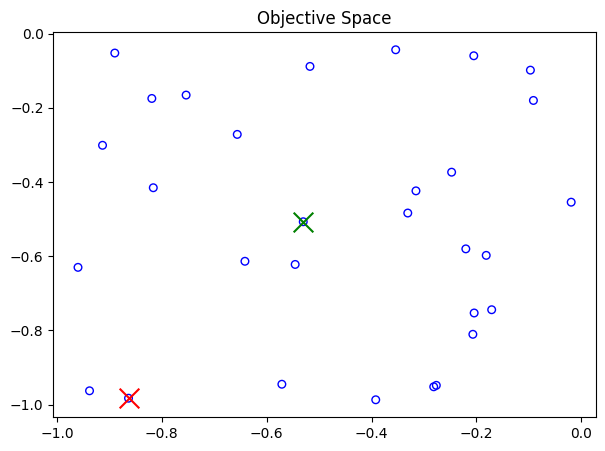

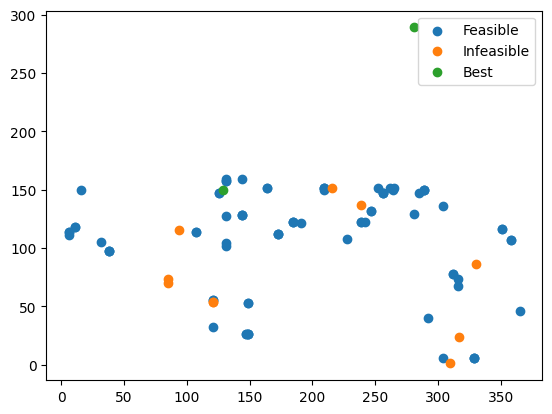

In [17]:
# https://pymoo.org/getting_started/part_3.html
F = allres.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
from pymoo.mcdm.pseudo_weights import PseudoWeights
from pymoo.decomposition.asf import ASF
decomp = ASF()
weights = np.array([0.0625]*16)
i = decomp.do(nF, 1/weights).argmin()
print("Best regarding ASF: Point \ni = %s\n" % (i))
j = PseudoWeights(weights).do(nF)
print("Best regarding Pseudo Weights: Point \nj = %s\n" % (j))
# for i in range(len(fl)):
#     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
# print(nF[:,0], nF[:,1])
plt.figure(figsize=(7, 5))
plt.scatter(F[:,0], F[:,1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="green", s=200)
plt.scatter(F[j, 0], F[j, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()
_X = np.row_stack([a.pop.get("X") for a in allres.history])
feasible = np.row_stack([a.pop.get("feasible") for a in allres.history])[:, 0]

plotting.plot(_X[feasible], _X[np.logical_not(feasible)], allres.X[None,:]
            , labels=["Feasible", "Infeasible", "Best"])

In [19]:
# https://pymoo.org/getting_started/part_3.html
for res in results1:
    F = res.F
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

    fl = nF.min(axis=0)
    fu = nF.max(axis=0)
    from pymoo.mcdm.pseudo_weights import PseudoWeights
    from pymoo.decomposition.asf import ASF
    decomp = ASF()
    weights = np.array([0.0625]*16)
    i = decomp.do(nF, 1/weights).argmin()
    print("Best regarding ASF: Point \ni = %s\n" % (i))
    j = PseudoWeights(weights).do(nF)
    print("Best regarding Pseudo Weights: Point \nj = %s\n" % (j))
    # plt.figure(figsize=(7, 5))
    # plt.scatter(F[:,0], F[:,1], s=30, facecolors='none', edgecolors='blue')
    # plt.scatter(F[i, 0], F[i, 1], marker="x", color="green", s=200)
    # plt.scatter(F[j, 0], F[j, 1], marker="x", color="red", s=200)
    # plt.title("Objective Space")
    # plt.show()
    # _X = np.row_stack([a.pop.get("X") for a in res.history])
    # feasible = np.row_stack([a.pop.get("feasible") for a in res.history])[:, 0]

    # plotting.plot(_X[feasible], _X[np.logical_not(feasible)], res.X[None,:]
    #           , labels=["Feasible", "Infeasible", "Best"])

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 0

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 0

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 1

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 1

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 0

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 0

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 0



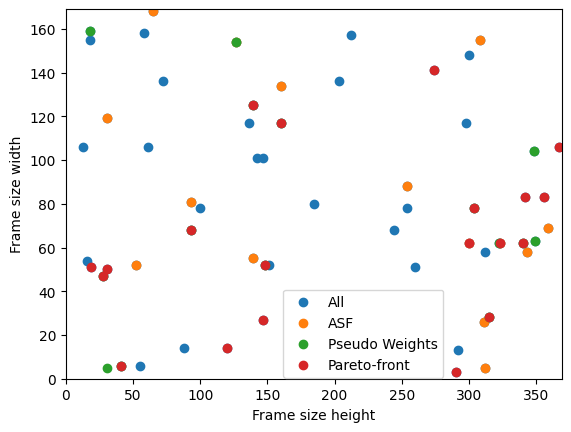

In [8]:
# Frame sizes for runs with the first version of the chaotization.
frame_sizes = [[19,51],	[244,68],	[16,54],	[147,101],	[142,101],	[147,27],	[72,136],	[367,106],	[61,106],	[290,3],	[136,117],	[298,117],	[88,14],	[356,83],	[55,6],
[359,69],	[349,63],	[342,83],	[300,62],	[348,104],	[18,155],	[311,26],	[185,80],	[315,28],	[93,81],	[100,78],	[93,68],	[308,155],	[304,78],	[300,148],
[52,52],	[13,106],	[28,47],	[254,88],	[254,78],	[139,125],	[139,55],	[151,52],	[148,52],	[323,62],	[260,51],	[322,62],	[343,58],	[340,62],	[312,58],
[312,5],	[292,13],	[41,6],	[127,154],	[58,158],	[120,14],	[65,168],	[274,141],	[18,159],	[31,119],	[212,157],	[31,50],	[160,134],	[203,136],	[160,117]
]
ASF_FS = [[312,5],[127,154],[65,168],[31,119],[160,134],[52,52],[254,88],[139,55],[323,62],[343,58],[359,69],[300,62],[311,26],[93,81],[308,155],]
PseudoWeights_FS = [[41,6],[127,154],[18,159],[31,5],[160,117],[28,47],[139,125],[148,52],[322,62],[340,62],[349,63],[348,104],[315,28],[93,68],[304,78],]
Pareto_FS = [[160,117],[31,50],[274,141],[120,14],[41,6],[28,47],[139,125],[148,52],[323,62],[340,62],[304,78],[93,68],[315,28],[300,62],[342,83],[356,83],[290,3],[367,106],[147,27],[19,51],	]

xAll, xASF, xPW, xPT = list(zip(*frame_sizes))[0], list(zip(*ASF_FS))[0], list(zip(*PseudoWeights_FS))[0], list(zip(*Pareto_FS))[0]
yAll, yASF, yPW, yPT = list(zip(*frame_sizes))[1], list(zip(*ASF_FS))[1], list(zip(*PseudoWeights_FS))[1], list(zip(*Pareto_FS))[1]

fig, ax = plt.subplots()
ax.set_xlim((0,369))
ax.set_ylim((0,169))
ax.set_xlabel("Frame size height")
ax.set_ylabel("Frame size width")
ax.scatter(xAll, yAll, label="All")
ax.scatter(xASF, yASF, label="ASF")
ax.scatter(xPW, yPW, label="Pseudo Weights")
ax.scatter(xPT, yPT, label="Pareto-front")
plt.legend(bbox_to_anchor=(0.6, 0.26))
plt.show()

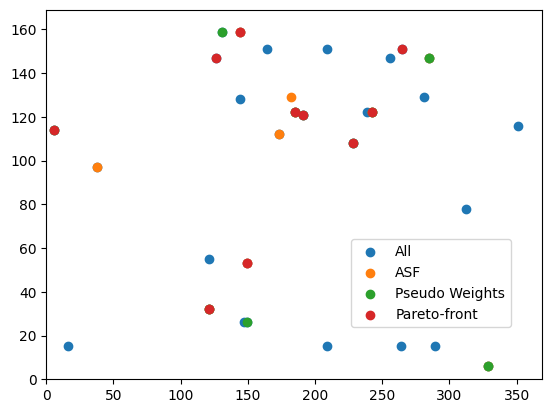

In [20]:
# Frame sizes for runs with the second version of the chaotization.
frame_sizes = [[281,129],	[289,15],	[6,114],	[185,122],	[209,15],	[209,151],	[173,112],	[351,116],	[191,121],	[121,32],	[121,55],	[164,151],	[38,97],	[228,108],	[16,15],
[149,53],	[149,26],	[147,26],	[285,147],	[256,147],	[126,147],	[144,159],	[144,128],	[131,159],	[242,122],	[312,78],	[239,122],	[329,6],	[265,151],	[264,15]
]
ASF_FS = [[182,129],[185,122],[173,112],[121,32],[38,97],[149,53],[285,147],[144,159],[242,122],[329,6]]
PseudoWeights_FS = [[6,114],[185,122],[191,121],[121,32],[228,108],[149,26],[285,147],[131,159],[242,122],[329,6]]
Pareto_FS = [[6,114],[185,122],[191,121],[121,32],[228,108],[149,53],[126,147],[144,159],[242,122],[265,151]]

xAll, xASF, xPW, xPT = list(zip(*frame_sizes))[0], list(zip(*ASF_FS))[0], list(zip(*PseudoWeights_FS))[0], list(zip(*Pareto_FS))[0]
yAll, yASF, yPW, yPT = list(zip(*frame_sizes))[1], list(zip(*ASF_FS))[1], list(zip(*PseudoWeights_FS))[1], list(zip(*Pareto_FS))[1]

fig, ax = plt.subplots()
ax.set_xlim((0,369))
ax.set_ylim((0,169))
ax.set_xlabel("Frame size height")
ax.set_ylabel("Frame size width")
ax.scatter(xAll, yAll, label="All")
ax.scatter(xASF, yASF, label="ASF")
ax.scatter(xPW, yPW, label="Pseudo Weights")
ax.scatter(xPT, yPT, label="Pareto-front")
plt.legend(bbox_to_anchor=(0.6, 0.26))
plt.show()